# Classification Bird Audio

In this notebook, we are going to train a CNN and a RNN on the dataset provided by Cornell Birdcall Identification (https://www.kaggle.com/c/birdsong-recognition)

### Import libraries

#### Load the data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import librosa
from pydub import AudioSegment
from IPython.display import Audio
import librosa.display
import os
import sklearn
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

In [33]:
#Import and display the first 3 audiotracks
dataframe = pd.read_csv('data/train.csv')
dataframe.head(3)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


### Preprocessing

Since the dataset rating probably indicates how 'good' the audiofile is, and since it takes a significant time to convert all the audiofiles to melspectorgrams we decided to only use ratings of 5

<AxesSubplot:>

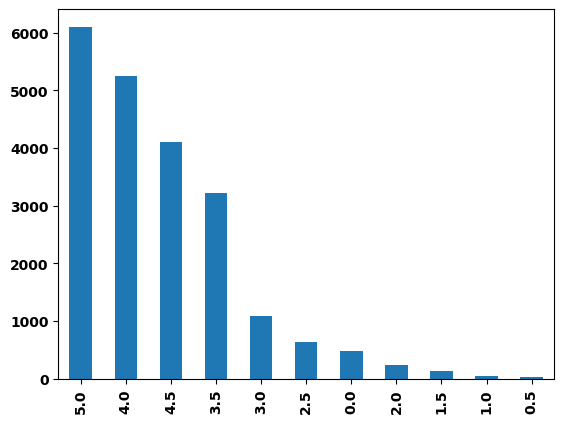

In [ ]:
dataframe['rating'].value_counts().plot(kind = 'bar')

In [34]:
dataframe_rating = dataframe.loc[dataframe['rating'] == 5]
dataframe_rating.head(3)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
12,5.0,no,aldfly,2 (stereo),2008-07-02,Not specified,19,XC142065.mp3,Not specified,Alder Flycatcher,...,142065,https://www.xeno-canto.org/142065,United States,Paul Driver,Empidonax alnorum_Alder Flycatcher,-68.9242,Not specified,06:00,Paul Driver,Creative Commons Attribution-NonCommercial-Sha...
19,5.0,no,aldfly,2 (stereo),2013-07-18,Not specified,84,XC144675.mp3,Not specified,Alder Flycatcher,...,144675,https://www.xeno-canto.org/144675,United States,Paul Driver,Empidonax alnorum_Alder Flycatcher,-68.312,Not specified,06:20,Paul Driver,Creative Commons Attribution-NonCommercial-Sha...
55,5.0,no,aldfly,2 (stereo),2014-07-20,Not specified,116,XC194088.mp3,Not specified,Alder Flycatcher,...,194088,https://www.xeno-canto.org/194088,Canada,Martin St-Michel,Empidonax alnorum_Alder Flycatcher,-69.9631,Not specified,07:10,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...


As the plot below shows, each bird have a different number of audiofiles available. Since its hard for a model to learn from a class with few occurences and since it would be beneficial to reduce the audiosamples while not reducing the nr of birdclasses to much we chose to only use the bird that have over 50 and under 80 occurences.

<AxesSubplot:>

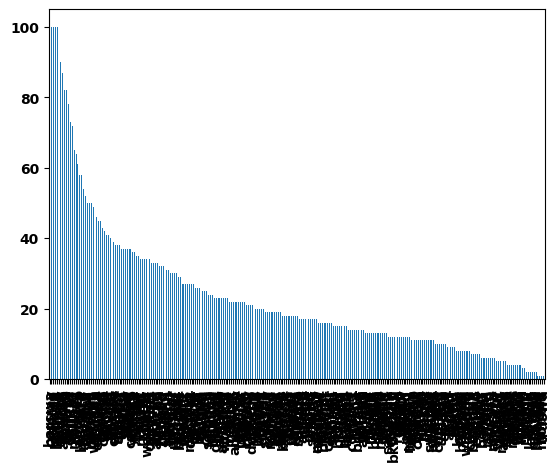

In [ ]:
dataframe_rating['ebird_code'].value_counts().plot(kind='bar')


In [35]:

occrences = dataframe_rating['ebird_code'].value_counts(sort = False)
unique_birds = dataframe_rating.ebird_code.unique()
birds_over = {}
for occurence, bird in zip(occrences, unique_birds):
    if occurence >= 50 and occurence <= 80:
        birds_over[bird] = occurence

dataframe_rating_over = dataframe_rating[dataframe_rating['ebird_code'].isin(list(birds_over.keys()))]
print(f'Nr of birds: {len(dataframe_rating_over.ebird_code.unique())} \nNr of audiosamples: {len(dataframe_rating_over)}')

Nr of birds: 13 
Nr of audiosamples: 785


"\nbirds_over_1 = {}\noccurs = dataframe_rating['ebird_code'].value_counts(sort = True)\nprint(occurs)\nunique_birds = dataframe_rating.ebird_code.unique()\nfor u in unique_birds:\n    if occurs[u] >=100:\n        birds_over_1[u] = occurs[u]\ndataframe_rating_over = dataframe_rating[dataframe_rating['ebird_code'].isin(list(birds_over_1.keys())[2:5])]\nprint(f'Nr of birds: {len(dataframe_rating_over.ebird_code.unique())} \nNr of audiosamples: {len(dataframe_rating_over)}')\n"

Now we apply some data augmentation to the dataset

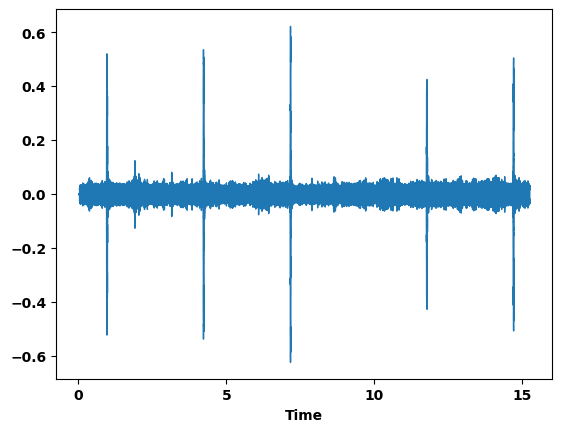

In [ ]:

audio = AudioSegment.from_mp3('data/train_audio/aldfly/XC2628.mp3')
temp_wav = "temp.wav"
audio.export(temp_wav, format="wav")
y, sr = librosa.load(temp_wav)

librosa.display.waveshow(y, sr = sr)
Audio(y, rate = sr)

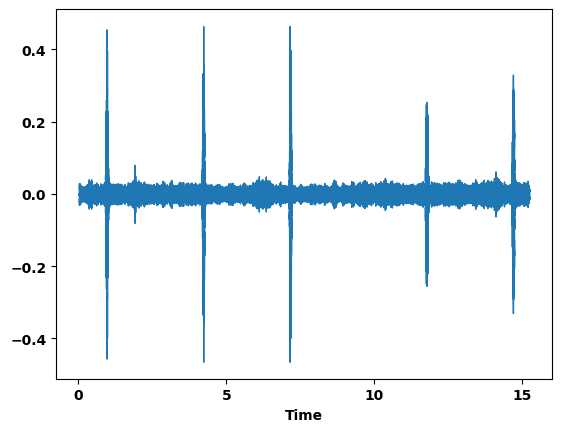

In [ ]:
y_pitch = librosa.effects.pitch_shift(y, sr = sr, n_steps=8)
librosa.display.waveshow(y_pitch, sr = sr)
Audio(y_pitch, rate = sr)

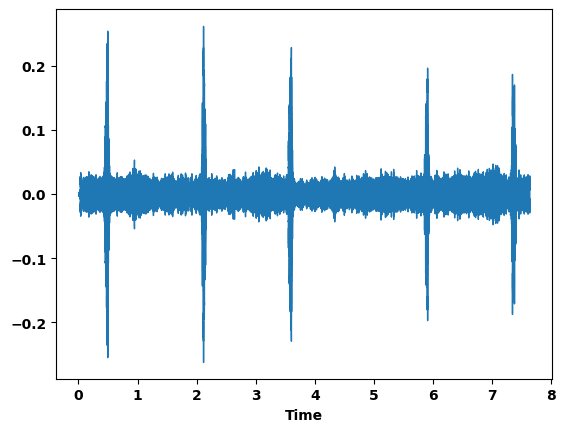

In [ ]:
y_speedup = librosa.effects.time_stretch(y, rate=2.0)
librosa.display.waveshow(y_speedup, sr = sr)
Audio(y_speedup, rate = sr)

In [13]:
def save_melspectrogram(path, birds, nr):
  if os.path.exists(f'data/melspectrogram/{birds}') == False:
    os.mkdir(f'data/melspectrogram/{birds}')
  audio = AudioSegment.from_mp3(path)
  temp_wav = "temp.wav"
  audio.export(temp_wav, format="wav")
  y, sr = librosa.load(temp_wav)
  y_trim, _ = librosa.effects.trim(y)
  y_speedup = librosa.effects.time_stretch(y_trim, rate = np.random.uniform(0.8, 1.2))
  noice = np.random.randn(len(y_speedup))
  y_speedup = y_speedup + 0.01*noice
  y_pitch = librosa.effects.pitch_shift(y_speedup, sr = sr, n_steps = np.random.randint(-2, 2))
  sample_time = sr * 5
  sample_song = []
  ver = 0
  for i in range(0, len(y_pitch), sample_time):
    sample_song = y_pitch[i:i+sample_time]
    if len(sample_song) >= sample_time:
      ver += 1
      mel_spectrogram = librosa.feature.melspectrogram(y = sample_song,  n_mels = 216)
      M_db = librosa.power_to_db(mel_spectrogram)
      Norm_M_db = np.array(sklearn.preprocessing.minmax_scale(M_db)*255).astype(np.uint8)
      Norm_M_db_image = Image.fromarray(Norm_M_db)
      save_path = f'data/melspectrogram/{birds}/x{nr}_{ver}.jpg'
      Norm_M_db_image.save(save_path)

In [14]:
with tqdm(total=len(dataframe_rating_over)) as pbar:
    for b in range(len(dataframe_rating_over)):
        pbar.update(1)
        #b += 3757
        bird_path = os.path.join('data/train_audio', dataframe_rating_over['ebird_code'].iloc[b], dataframe_rating_over['filename'].iloc[b]).replace('\\', '/')
        bird = dataframe_rating_over['ebird_code'].iloc[b]
        save_melspectrogram(bird_path, bird, b)

100%|██████████| 300/300 [33:25<00:00,  6.68s/it] 


Note: It took 26 min for the small RNN dataset preprocessing

In [36]:
def save_mfcc(path, birds, filename,nr, saved_df):
    if os.path.exists(f'data/mfcc/{birds}') == False:
        os.mkdir(f'data/mfcc/{birds}')
    audio = AudioSegment.from_mp3(path)
    temp_wav = "temp.wav"
    audio.export(temp_wav, format="wav")
    y, sr = librosa.load(temp_wav)
    y_trim, _ = librosa.effects.trim(y)
    y_speedup = librosa.effects.time_stretch(y_trim, rate=np.random.uniform(0.6, 1.4))
    noice = np.random.randn(len(y_speedup))
    y_speedup = y_speedup + 0.01*noice
    y_pitch = librosa.effects.pitch_shift(y_speedup, sr = sr, n_steps=np.random.randint(-2, 2))
    sample_time = sr * 5
    sample_song = []
    ver = 0
    for i in range(0, len(y), sample_time):
        sample_song = y_pitch[i:i+sample_time]
        if len(sample_song) >= sample_time:
            ver += 1
            mfcc = librosa.feature.mfcc(y = sample_song,  n_mels = 20)
            save_path = f'data/mfcc/{birds}/x{nr}_{ver}.csv'
            df = pd.DataFrame({"save_path":[save_path], "ebird_code":[birds]})
            saved_df = saved_df.append(df, ignore_index=True)
            os.path.expanduser(save_path)
            np.savetxt(save_path, mfcc, delimiter=",") 
    return saved_df


saved_df = pd.DataFrame(columns = ['save_path', 'ebird_code'])           
with tqdm(total=len(dataframe_rating_over)) as pbar:
    for b in range(len(dataframe_rating_over)):
        pbar.update(1)
        #b += 3757
        bird_path = os.path.join('data/train_audio', dataframe_rating_over['ebird_code'].iloc[b], dataframe_rating_over['filename'].iloc[b]).replace('\\', '/')
        bird = dataframe_rating_over['ebird_code'].iloc[b]
        filename = dataframe_rating_over['filename'].iloc[b]
        saved_df = save_mfcc(bird_path, bird, filename,b, saved_df)
        
saved_df.to_csv('data/saved_df.csv', index=False)

  0%|          | 0/785 [00:00<?, ?it/s]C:\Users\lukas\AppData\Local\Temp\ipykernel_18264\3692582191.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  saved_df = saved_df.append(df, ignore_index=True)
100%|██████████| 785/785 [1:16:17<00:00,  5.83s/it]


Note: It took 39 min for the small CNN dataset preprocessing